## **LIBRARIES IMPORTED AND SETUP**

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import random
import seaborn as sns
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) 

# Setup device (gpu or cpu)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla T4


## **NEW DATASET LOADER**

In [3]:
def get_transforms(size, normalize, split):
    """
    Get data transforms for CIFAR100

    Args:
        size: Image size ('32' or '224')
        normalize: Normalization type ('standard' or 'imagenet')
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
    Returns:
        torchvision.transforms.Compose object
    """
    if normalize == "imagenet":
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == "standard":
        mean = [0.5071, 0.4865, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
    transform_list = []
    # Add data augmentation for training
    if split == "train":
        if size == "224":
            train_transform = transform_list.extend(
                [
                    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
                ]
            )
        elif size == "32":
            train_transform = transform_list.extend(
                [
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                ]
            )
    elif split == "test":
        if size == "224":
            test_transform = transform_list.extend(
                [
                    transforms.Resize((224, 224)),
                ]
            )

    # Add basic transforms
    transform_list.extend([transforms.ToTensor(), transforms.Normalize(mean, std)])

    return transforms.Compose(transform_list)

In [4]:
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)
    torch.manual_seed(SEED + worker_id)

In [5]:
def CIFAR100DataLoader_v2(
    split,
    batch_size=8,
    num_workers=2,
    shuffle=True,
    size="32",
    normalize="standard",
    seed=42,
):
    """
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')

    Output:
        DataLoader Object
    """

    # Get appropriate transforms
    transforms = get_transforms(size, normalize, split)
    if split == "train":
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=True, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )
    else:
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=False, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )

## **VIT MODEL SETUP**

In [6]:
# Attention layer
class Attention(nn.Module):
    """
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :-
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    """

    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) |
        # reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) |
        # Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)

        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Feed Forward layer
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    """
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    """

    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block
class TransformerBlock(nn.Module):
    """
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-

    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    """

    def __init__(
        self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1
    ):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res

        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block with multi layer
class Transformer(nn.Module):
    """
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    """

    def __init__(
        self,
        embed_dim,
        layers,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim, heads, activation, forward_expansion, dropout
                )
                for i in range(layers)
            ]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# MLP Head
class ClassificationHead(nn.Module):
    """
    Classification Head attached to the first sequence token which is used as the arbitrary
    classification token and used to optimize the transformer model by applying Cross-Entropy
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    """

    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes)
        return out


class VisionTransformer(nn.Module):
    """
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|

    Args:
        patch_size: Length of square patch size
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)

    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    """

    def __init__(
        self,
        patch_size,
        max_len,
        embed_dim,
        classes,
        layers,
        channels=3,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        self.name = "VisionTransformer"
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(
            embed_dim, layers, heads, activation, forward_expansion, dropout
        )
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        # Split image into small patch
        out = (
            inp.unfold(2, self.patch_size, self.patch_size)
            .unfold(3, self.patch_size, self.patch_size)
            .contiguous()
        )
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) |
        # seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()

        # Flatten patch into 1 dimension
        out = out.reshape(batch_size, seq_len, -1)
        # Mapping from patch 1 dimension to hidden embedding dimension
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        # Add class token to head of embedding vector
        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[: seq_len + 1]
        position_embed = position_embed.unsqueeze(0).expand(
            batch_size, seq_len + 1, self.embed_dim
        )
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim)
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)

        return class_out, out

## **TRAINING, EVALUATION AND TESTING FUNCTION**

In [7]:
# Training model
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    """
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    """
    running_loss = 0.0
    running_accuracy = 0.0
    index = 0
    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)
        if model.name == "VisionTransformer":
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == "ResNet":
            output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy


# Validation model
def evaluation(model, dataloader, criterion, resnet_features=None):
    """
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    """
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy


def test(model, dataloader, resnet_features=None):
    """
    Function used to test the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        all_preds: All model predict label (Int)
        all_labels: All dataset label (Int)
    """
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for data, label in tqdm(dataloader):
            data = data.to(device)
            target = label.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)

            pred = output.argmax(dim=1)
            all_preds.extend(pred)
            all_labels.extend(label)

    return all_preds, all_labels

## **INITIALIZE VARIABLE**

In [8]:
max_len = 100  # All sequences must be less than 1000 including class token
classes = 100
image_sz = 32
channels = 3

lr = 0.001
epochs = 100

patch_size = 8
batch_size = 32
num_workers = 2
shuffle = True

embed_dim = 384

layers = 12
heads = 12

resnet_features_channels = 64

In [9]:
# Init model
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads,
).to(device)

resnet_features = None

## **TRAINING AND TEST**

In [10]:
# Init data loader
train_dataloader = CIFAR100DataLoader_v2(
    split="train",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=shuffle,
    size="32",
    normalize="standard",
)
test_dataloader = CIFAR100DataLoader_v2(
    split="test",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    size="32",
    normalize="standard",
)

100%|██████████| 169001437/169001437 [00:04<00:00, 39306079.64it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
# Initialize first time training
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs
)

train_accs = []
test_accs = []
last_epoch = 0

In [12]:
# Record the start time
start_time = time.time()
# Running
for epoch in range(epochs - last_epoch):
    epoch += last_epoch
    running_loss, running_accuracy = train(
        model, train_dataloader, criterion, optimizer, scheduler, resnet_features
    )
    print(
        f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n"
    )
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(
        model, test_dataloader, criterion, resnet_features
    )
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch + 1) % 5 == 0:
        torch.save(
            {
                "epoch": epoch,
                "model": model,
                "optimizer": optimizer,
                "scheduler": scheduler,
                "train_acc": train_accs,
                "test_acc": test_accs,
            },
            model.name + "_patch8-384d-12h-12l_CIFAR100_checkpoint_" + str(epoch) + ".pt",
        )

torch.save(
    {
        "epoch": epoch,
        "model": model,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "train_acc": train_accs,
        "test_acc": test_accs,
    },
    model.name + "_patch8-384d-12h-12l_CIFAR100.pt",
)

# Record the end time
end_time = time.time()
# Calculate the time difference
time_difference = end_time - start_time

print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
# print(f"Time Taken: {time_difference} seconds")

100%|██████████| 1563/1563 [00:51<00:00, 30.51it/s]


Epoch : 1 - acc: 0.0728 - loss : 4.1445



100%|██████████| 313/313 [00:04<00:00, 77.33it/s]


test acc: 0.1123 - test loss : 3.8486



100%|██████████| 1563/1563 [00:49<00:00, 31.37it/s]


Epoch : 2 - acc: 0.1222 - loss : 3.7798



100%|██████████| 313/313 [00:03<00:00, 83.96it/s]


test acc: 0.1517 - test loss : 3.6379



100%|██████████| 1563/1563 [00:50<00:00, 31.03it/s]


Epoch : 3 - acc: 0.1499 - loss : 3.5973



100%|██████████| 313/313 [00:03<00:00, 84.56it/s]


test acc: 0.1756 - test loss : 3.4952



100%|██████████| 1563/1563 [00:50<00:00, 31.19it/s]


Epoch : 4 - acc: 0.1718 - loss : 3.4665



100%|██████████| 313/313 [00:03<00:00, 88.94it/s]


test acc: 0.1918 - test loss : 3.3810



100%|██████████| 1563/1563 [00:50<00:00, 31.21it/s]


Epoch : 5 - acc: 0.1891 - loss : 3.3733



100%|██████████| 313/313 [00:03<00:00, 81.44it/s]


test acc: 0.1997 - test loss : 3.3208



100%|██████████| 1563/1563 [00:50<00:00, 31.09it/s]


Epoch : 6 - acc: 0.2012 - loss : 3.2985



100%|██████████| 313/313 [00:03<00:00, 88.67it/s]


test acc: 0.2181 - test loss : 3.2493



100%|██████████| 1563/1563 [00:49<00:00, 31.64it/s]


Epoch : 7 - acc: 0.2117 - loss : 3.2327



100%|██████████| 313/313 [00:03<00:00, 84.30it/s]


test acc: 0.2257 - test loss : 3.1954



100%|██████████| 1563/1563 [00:49<00:00, 31.29it/s]


Epoch : 8 - acc: 0.2230 - loss : 3.1815



100%|██████████| 313/313 [00:03<00:00, 84.64it/s]


test acc: 0.2337 - test loss : 3.1514



100%|██████████| 1563/1563 [00:50<00:00, 30.78it/s]


Epoch : 9 - acc: 0.2333 - loss : 3.1258



100%|██████████| 313/313 [00:03<00:00, 83.45it/s]


test acc: 0.2421 - test loss : 3.1236



100%|██████████| 1563/1563 [00:50<00:00, 30.97it/s]


Epoch : 10 - acc: 0.2393 - loss : 3.0896



100%|██████████| 313/313 [00:03<00:00, 84.94it/s]


test acc: 0.2453 - test loss : 3.1024



100%|██████████| 1563/1563 [00:50<00:00, 30.87it/s]


Epoch : 11 - acc: 0.2501 - loss : 3.0420



100%|██████████| 313/313 [00:03<00:00, 80.58it/s]


test acc: 0.2469 - test loss : 3.0551



100%|██████████| 1563/1563 [00:49<00:00, 31.46it/s]


Epoch : 12 - acc: 0.2570 - loss : 3.0044



100%|██████████| 313/313 [00:03<00:00, 82.79it/s]


test acc: 0.2513 - test loss : 3.0583



100%|██████████| 1563/1563 [00:50<00:00, 31.03it/s]


Epoch : 13 - acc: 0.2611 - loss : 2.9730



100%|██████████| 313/313 [00:03<00:00, 78.72it/s]


test acc: 0.2646 - test loss : 3.0029



100%|██████████| 1563/1563 [00:50<00:00, 31.11it/s]


Epoch : 14 - acc: 0.2679 - loss : 2.9359



100%|██████████| 313/313 [00:03<00:00, 88.88it/s]


test acc: 0.2676 - test loss : 2.9752



100%|██████████| 1563/1563 [00:50<00:00, 31.14it/s]


Epoch : 15 - acc: 0.2740 - loss : 2.9037



100%|██████████| 313/313 [00:04<00:00, 75.48it/s]


test acc: 0.2760 - test loss : 2.9391



100%|██████████| 1563/1563 [00:51<00:00, 30.51it/s]


Epoch : 16 - acc: 0.2812 - loss : 2.8740



100%|██████████| 313/313 [00:03<00:00, 81.48it/s]


test acc: 0.2742 - test loss : 2.9413



100%|██████████| 1563/1563 [00:50<00:00, 30.97it/s]


Epoch : 17 - acc: 0.2846 - loss : 2.8432



100%|██████████| 313/313 [00:03<00:00, 85.32it/s]


test acc: 0.2841 - test loss : 2.9060



100%|██████████| 1563/1563 [00:50<00:00, 31.03it/s]


Epoch : 18 - acc: 0.2914 - loss : 2.8212



100%|██████████| 313/313 [00:04<00:00, 76.75it/s]


test acc: 0.2906 - test loss : 2.8848



100%|██████████| 1563/1563 [00:49<00:00, 31.29it/s]


Epoch : 19 - acc: 0.2955 - loss : 2.7889



100%|██████████| 313/313 [00:04<00:00, 77.18it/s]


test acc: 0.2890 - test loss : 2.8782



100%|██████████| 1563/1563 [00:49<00:00, 31.28it/s]


Epoch : 20 - acc: 0.3026 - loss : 2.7606



100%|██████████| 313/313 [00:03<00:00, 88.44it/s]


test acc: 0.2951 - test loss : 2.8514



100%|██████████| 1563/1563 [00:50<00:00, 30.88it/s]


Epoch : 21 - acc: 0.3058 - loss : 2.7364



100%|██████████| 313/313 [00:03<00:00, 88.97it/s]


test acc: 0.2954 - test loss : 2.8502



100%|██████████| 1563/1563 [00:50<00:00, 31.16it/s]


Epoch : 22 - acc: 0.3105 - loss : 2.7119



100%|██████████| 313/313 [00:03<00:00, 82.62it/s]


test acc: 0.2970 - test loss : 2.8404



100%|██████████| 1563/1563 [00:49<00:00, 31.48it/s]


Epoch : 23 - acc: 0.3150 - loss : 2.6915



100%|██████████| 313/313 [00:03<00:00, 85.36it/s]


test acc: 0.3046 - test loss : 2.8118



100%|██████████| 1563/1563 [00:50<00:00, 31.10it/s]


Epoch : 24 - acc: 0.3220 - loss : 2.6659



100%|██████████| 313/313 [00:03<00:00, 83.37it/s]


test acc: 0.3079 - test loss : 2.8006



100%|██████████| 1563/1563 [00:49<00:00, 31.30it/s]


Epoch : 25 - acc: 0.3241 - loss : 2.6368



100%|██████████| 313/313 [00:04<00:00, 76.31it/s]


test acc: 0.3056 - test loss : 2.7875



100%|██████████| 1563/1563 [00:50<00:00, 31.22it/s]


Epoch : 26 - acc: 0.3303 - loss : 2.6155



100%|██████████| 313/313 [00:03<00:00, 83.35it/s]


test acc: 0.3151 - test loss : 2.7754



100%|██████████| 1563/1563 [00:49<00:00, 31.47it/s]


Epoch : 27 - acc: 0.3368 - loss : 2.5960



100%|██████████| 313/313 [00:03<00:00, 87.00it/s]


test acc: 0.3134 - test loss : 2.7669



100%|██████████| 1563/1563 [00:50<00:00, 31.23it/s]


Epoch : 28 - acc: 0.3374 - loss : 2.5793



100%|██████████| 313/313 [00:04<00:00, 76.97it/s]


test acc: 0.3154 - test loss : 2.7388



100%|██████████| 1563/1563 [00:49<00:00, 31.35it/s]


Epoch : 29 - acc: 0.3453 - loss : 2.5485



100%|██████████| 313/313 [00:03<00:00, 93.15it/s]


test acc: 0.3218 - test loss : 2.7290



100%|██████████| 1563/1563 [00:50<00:00, 31.15it/s]


Epoch : 30 - acc: 0.3476 - loss : 2.5310



100%|██████████| 313/313 [00:03<00:00, 87.43it/s]


test acc: 0.3213 - test loss : 2.7302



100%|██████████| 1563/1563 [00:50<00:00, 31.11it/s]


Epoch : 31 - acc: 0.3525 - loss : 2.5116



100%|██████████| 313/313 [00:03<00:00, 84.26it/s]


test acc: 0.3217 - test loss : 2.7143



100%|██████████| 1563/1563 [00:49<00:00, 31.68it/s]


Epoch : 32 - acc: 0.3556 - loss : 2.4829



100%|██████████| 313/313 [00:03<00:00, 86.63it/s]


test acc: 0.3310 - test loss : 2.6951



100%|██████████| 1563/1563 [00:49<00:00, 31.40it/s]


Epoch : 33 - acc: 0.3638 - loss : 2.4617



100%|██████████| 313/313 [00:03<00:00, 81.50it/s]


test acc: 0.3280 - test loss : 2.7001



100%|██████████| 1563/1563 [00:49<00:00, 31.56it/s]


Epoch : 34 - acc: 0.3646 - loss : 2.4443



100%|██████████| 313/313 [00:03<00:00, 80.93it/s]


test acc: 0.3366 - test loss : 2.6732



100%|██████████| 1563/1563 [00:49<00:00, 31.43it/s]


Epoch : 35 - acc: 0.3706 - loss : 2.4199



100%|██████████| 313/313 [00:03<00:00, 84.87it/s]


test acc: 0.3336 - test loss : 2.6599



100%|██████████| 1563/1563 [00:50<00:00, 30.96it/s]


Epoch : 36 - acc: 0.3756 - loss : 2.3918



100%|██████████| 313/313 [00:03<00:00, 88.17it/s]


test acc: 0.3382 - test loss : 2.6541



100%|██████████| 1563/1563 [00:49<00:00, 31.87it/s]


Epoch : 37 - acc: 0.3818 - loss : 2.3715



100%|██████████| 313/313 [00:03<00:00, 86.88it/s]


test acc: 0.3468 - test loss : 2.6391



100%|██████████| 1563/1563 [00:50<00:00, 31.18it/s]


Epoch : 38 - acc: 0.3858 - loss : 2.3539



100%|██████████| 313/313 [00:03<00:00, 81.47it/s]


test acc: 0.3466 - test loss : 2.6357



100%|██████████| 1563/1563 [00:49<00:00, 31.67it/s]


Epoch : 39 - acc: 0.3892 - loss : 2.3316



100%|██████████| 313/313 [00:03<00:00, 86.07it/s]


test acc: 0.3444 - test loss : 2.6237



100%|██████████| 1563/1563 [00:49<00:00, 31.89it/s]


Epoch : 40 - acc: 0.3920 - loss : 2.3141



100%|██████████| 313/313 [00:03<00:00, 83.51it/s]


test acc: 0.3432 - test loss : 2.6340



100%|██████████| 1563/1563 [00:49<00:00, 31.79it/s]


Epoch : 41 - acc: 0.3963 - loss : 2.2927



100%|██████████| 313/313 [00:04<00:00, 74.61it/s]


test acc: 0.3506 - test loss : 2.6183



100%|██████████| 1563/1563 [00:49<00:00, 31.65it/s]


Epoch : 42 - acc: 0.3989 - loss : 2.2792



100%|██████████| 313/313 [00:03<00:00, 87.81it/s]


test acc: 0.3497 - test loss : 2.6191



100%|██████████| 1563/1563 [00:51<00:00, 30.51it/s]


Epoch : 43 - acc: 0.4091 - loss : 2.2516



100%|██████████| 313/313 [00:03<00:00, 81.67it/s]


test acc: 0.3573 - test loss : 2.6056



100%|██████████| 1563/1563 [00:50<00:00, 31.10it/s]


Epoch : 44 - acc: 0.4087 - loss : 2.2356



100%|██████████| 313/313 [00:03<00:00, 81.00it/s]


test acc: 0.3591 - test loss : 2.5982



100%|██████████| 1563/1563 [00:50<00:00, 30.90it/s]


Epoch : 45 - acc: 0.4123 - loss : 2.2149



100%|██████████| 313/313 [00:03<00:00, 78.28it/s]


test acc: 0.3594 - test loss : 2.5740



100%|██████████| 1563/1563 [00:49<00:00, 31.53it/s]


Epoch : 46 - acc: 0.4170 - loss : 2.1925



100%|██████████| 313/313 [00:03<00:00, 87.48it/s]


test acc: 0.3600 - test loss : 2.5975



100%|██████████| 1563/1563 [00:50<00:00, 31.15it/s]


Epoch : 47 - acc: 0.4221 - loss : 2.1643



100%|██████████| 313/313 [00:03<00:00, 82.60it/s]


test acc: 0.3610 - test loss : 2.5854



100%|██████████| 1563/1563 [00:50<00:00, 31.20it/s]


Epoch : 48 - acc: 0.4291 - loss : 2.1523



100%|██████████| 313/313 [00:03<00:00, 78.53it/s]


test acc: 0.3641 - test loss : 2.5766



100%|██████████| 1563/1563 [00:50<00:00, 31.15it/s]


Epoch : 49 - acc: 0.4299 - loss : 2.1314



100%|██████████| 313/313 [00:03<00:00, 87.45it/s]


test acc: 0.3626 - test loss : 2.5805



100%|██████████| 1563/1563 [00:50<00:00, 30.97it/s]


Epoch : 50 - acc: 0.4370 - loss : 2.1111



100%|██████████| 313/313 [00:03<00:00, 85.72it/s]


test acc: 0.3625 - test loss : 2.5844



100%|██████████| 1563/1563 [00:50<00:00, 30.80it/s]


Epoch : 51 - acc: 0.4396 - loss : 2.0940



100%|██████████| 313/313 [00:03<00:00, 86.26it/s]


test acc: 0.3613 - test loss : 2.5881



100%|██████████| 1563/1563 [00:51<00:00, 30.35it/s]


Epoch : 52 - acc: 0.4439 - loss : 2.0758



100%|██████████| 313/313 [00:03<00:00, 79.03it/s]


test acc: 0.3632 - test loss : 2.5681



100%|██████████| 1563/1563 [00:51<00:00, 30.21it/s]


Epoch : 53 - acc: 0.4498 - loss : 2.0569



100%|██████████| 313/313 [00:03<00:00, 86.76it/s]


test acc: 0.3664 - test loss : 2.5679



100%|██████████| 1563/1563 [00:51<00:00, 30.33it/s]


Epoch : 54 - acc: 0.4515 - loss : 2.0374



100%|██████████| 313/313 [00:03<00:00, 85.48it/s]


test acc: 0.3750 - test loss : 2.5533



100%|██████████| 1563/1563 [00:52<00:00, 29.74it/s]


Epoch : 55 - acc: 0.4573 - loss : 2.0116



100%|██████████| 313/313 [00:03<00:00, 85.28it/s]


test acc: 0.3715 - test loss : 2.5672



100%|██████████| 1563/1563 [00:51<00:00, 30.38it/s]


Epoch : 56 - acc: 0.4612 - loss : 1.9968



100%|██████████| 313/313 [00:03<00:00, 83.99it/s]


test acc: 0.3726 - test loss : 2.5538



100%|██████████| 1563/1563 [00:51<00:00, 30.29it/s]


Epoch : 57 - acc: 0.4675 - loss : 1.9822



100%|██████████| 313/313 [00:03<00:00, 86.52it/s]


test acc: 0.3673 - test loss : 2.5870



100%|██████████| 1563/1563 [00:52<00:00, 29.53it/s]


Epoch : 58 - acc: 0.4670 - loss : 1.9576



100%|██████████| 313/313 [00:03<00:00, 83.45it/s]


test acc: 0.3789 - test loss : 2.5467



100%|██████████| 1563/1563 [00:51<00:00, 30.38it/s]


Epoch : 59 - acc: 0.4745 - loss : 1.9348



100%|██████████| 313/313 [00:03<00:00, 84.51it/s]


test acc: 0.3758 - test loss : 2.5595



100%|██████████| 1563/1563 [00:51<00:00, 30.15it/s]


Epoch : 60 - acc: 0.4791 - loss : 1.9187



100%|██████████| 313/313 [00:03<00:00, 83.00it/s]


test acc: 0.3721 - test loss : 2.5629



100%|██████████| 1563/1563 [00:52<00:00, 29.99it/s]


Epoch : 61 - acc: 0.4826 - loss : 1.8989



100%|██████████| 313/313 [00:03<00:00, 88.56it/s]


test acc: 0.3810 - test loss : 2.5598



100%|██████████| 1563/1563 [00:51<00:00, 30.61it/s]


Epoch : 62 - acc: 0.4886 - loss : 1.8769



100%|██████████| 313/313 [00:03<00:00, 79.98it/s]


test acc: 0.3747 - test loss : 2.5805



100%|██████████| 1563/1563 [00:53<00:00, 29.48it/s]


Epoch : 63 - acc: 0.4917 - loss : 1.8614



100%|██████████| 313/313 [00:03<00:00, 81.97it/s]


test acc: 0.3773 - test loss : 2.5708



100%|██████████| 1563/1563 [00:52<00:00, 29.60it/s]


Epoch : 64 - acc: 0.4964 - loss : 1.8356



100%|██████████| 313/313 [00:04<00:00, 72.62it/s]


test acc: 0.3770 - test loss : 2.5659



100%|██████████| 1563/1563 [00:52<00:00, 29.94it/s]


Epoch : 65 - acc: 0.5021 - loss : 1.8205



100%|██████████| 313/313 [00:03<00:00, 82.39it/s]


test acc: 0.3793 - test loss : 2.5561



100%|██████████| 1563/1563 [00:52<00:00, 29.55it/s]


Epoch : 66 - acc: 0.5016 - loss : 1.8164



100%|██████████| 313/313 [00:03<00:00, 78.81it/s]


test acc: 0.3792 - test loss : 2.5929



100%|██████████| 1563/1563 [00:51<00:00, 30.15it/s]


Epoch : 67 - acc: 0.5078 - loss : 1.7836



100%|██████████| 313/313 [00:03<00:00, 80.24it/s]


test acc: 0.3820 - test loss : 2.5597



100%|██████████| 1563/1563 [00:52<00:00, 30.05it/s]


Epoch : 68 - acc: 0.5146 - loss : 1.7580



100%|██████████| 313/313 [00:03<00:00, 80.16it/s]


test acc: 0.3804 - test loss : 2.5731



100%|██████████| 1563/1563 [00:52<00:00, 29.84it/s]


Epoch : 69 - acc: 0.5159 - loss : 1.7472



100%|██████████| 313/313 [00:04<00:00, 77.84it/s]


test acc: 0.3832 - test loss : 2.5798



100%|██████████| 1563/1563 [00:53<00:00, 29.45it/s]


Epoch : 70 - acc: 0.5210 - loss : 1.7252



100%|██████████| 313/313 [00:03<00:00, 83.50it/s]


test acc: 0.3765 - test loss : 2.5876



100%|██████████| 1563/1563 [00:52<00:00, 29.72it/s]


Epoch : 71 - acc: 0.5276 - loss : 1.7016



100%|██████████| 313/313 [00:03<00:00, 81.20it/s]


test acc: 0.3821 - test loss : 2.5895



100%|██████████| 1563/1563 [00:52<00:00, 29.87it/s]


Epoch : 72 - acc: 0.5313 - loss : 1.6796



100%|██████████| 313/313 [00:03<00:00, 82.98it/s]


test acc: 0.3864 - test loss : 2.6020



100%|██████████| 1563/1563 [00:52<00:00, 29.87it/s]


Epoch : 73 - acc: 0.5345 - loss : 1.6657



100%|██████████| 313/313 [00:04<00:00, 71.42it/s]


test acc: 0.3892 - test loss : 2.6000



100%|██████████| 1563/1563 [00:51<00:00, 30.30it/s]


Epoch : 74 - acc: 0.5406 - loss : 1.6463



100%|██████████| 313/313 [00:03<00:00, 83.49it/s]


test acc: 0.3886 - test loss : 2.5911



100%|██████████| 1563/1563 [00:53<00:00, 29.11it/s]


Epoch : 75 - acc: 0.5428 - loss : 1.6231



100%|██████████| 313/313 [00:03<00:00, 82.84it/s]


test acc: 0.3883 - test loss : 2.5924



100%|██████████| 1563/1563 [00:52<00:00, 29.84it/s]


Epoch : 76 - acc: 0.5495 - loss : 1.6118



100%|██████████| 313/313 [00:03<00:00, 82.76it/s]


test acc: 0.3896 - test loss : 2.5824



100%|██████████| 1563/1563 [00:53<00:00, 29.15it/s]


Epoch : 77 - acc: 0.5536 - loss : 1.5871



100%|██████████| 313/313 [00:04<00:00, 77.20it/s]


test acc: 0.3876 - test loss : 2.6030



100%|██████████| 1563/1563 [00:51<00:00, 30.11it/s]


Epoch : 78 - acc: 0.5597 - loss : 1.5671



100%|██████████| 313/313 [00:04<00:00, 74.91it/s]


test acc: 0.3935 - test loss : 2.5996



100%|██████████| 1563/1563 [00:52<00:00, 29.68it/s]


Epoch : 79 - acc: 0.5644 - loss : 1.5425



100%|██████████| 313/313 [00:03<00:00, 82.50it/s]


test acc: 0.3965 - test loss : 2.5971



100%|██████████| 1563/1563 [00:52<00:00, 29.92it/s]


Epoch : 80 - acc: 0.5706 - loss : 1.5177



100%|██████████| 313/313 [00:03<00:00, 85.67it/s]


test acc: 0.3884 - test loss : 2.6156



100%|██████████| 1563/1563 [00:52<00:00, 29.75it/s]


Epoch : 81 - acc: 0.5733 - loss : 1.5060



100%|██████████| 313/313 [00:03<00:00, 86.41it/s]


test acc: 0.3885 - test loss : 2.6222



100%|██████████| 1563/1563 [00:53<00:00, 29.42it/s]


Epoch : 82 - acc: 0.5772 - loss : 1.4891



100%|██████████| 313/313 [00:04<00:00, 75.31it/s]


test acc: 0.3828 - test loss : 2.6455



100%|██████████| 1563/1563 [00:51<00:00, 30.57it/s]


Epoch : 83 - acc: 0.5821 - loss : 1.4709



100%|██████████| 313/313 [00:04<00:00, 67.99it/s]


test acc: 0.3877 - test loss : 2.6509



100%|██████████| 1563/1563 [00:52<00:00, 29.81it/s]


Epoch : 84 - acc: 0.5889 - loss : 1.4420



100%|██████████| 313/313 [00:03<00:00, 78.32it/s]


test acc: 0.3949 - test loss : 2.6421



100%|██████████| 1563/1563 [00:52<00:00, 29.54it/s]


Epoch : 85 - acc: 0.5912 - loss : 1.4338



100%|██████████| 313/313 [00:03<00:00, 83.69it/s]


test acc: 0.3915 - test loss : 2.6590



100%|██████████| 1563/1563 [00:53<00:00, 29.14it/s]


Epoch : 86 - acc: 0.5966 - loss : 1.4063



100%|██████████| 313/313 [00:03<00:00, 86.95it/s]


test acc: 0.3837 - test loss : 2.7041



100%|██████████| 1563/1563 [00:52<00:00, 29.81it/s]


Epoch : 87 - acc: 0.5994 - loss : 1.3910



100%|██████████| 313/313 [00:04<00:00, 67.13it/s]


test acc: 0.3901 - test loss : 2.6851



100%|██████████| 1563/1563 [00:53<00:00, 29.40it/s]


Epoch : 88 - acc: 0.6072 - loss : 1.3661



100%|██████████| 313/313 [00:04<00:00, 77.06it/s]


test acc: 0.3931 - test loss : 2.6751



100%|██████████| 1563/1563 [00:52<00:00, 29.64it/s]


Epoch : 89 - acc: 0.6121 - loss : 1.3452



100%|██████████| 313/313 [00:03<00:00, 83.63it/s] 


test acc: 0.3918 - test loss : 2.6834



100%|██████████| 1563/1563 [00:53<00:00, 29.42it/s]


Epoch : 90 - acc: 0.6176 - loss : 1.3169



100%|██████████| 313/313 [00:03<00:00, 81.48it/s]


test acc: 0.3931 - test loss : 2.6791



100%|██████████| 1563/1563 [00:51<00:00, 30.18it/s]


Epoch : 91 - acc: 0.6205 - loss : 1.3054



100%|██████████| 313/313 [00:03<00:00, 83.91it/s]


test acc: 0.3954 - test loss : 2.7193



100%|██████████| 1563/1563 [00:52<00:00, 29.72it/s]


Epoch : 92 - acc: 0.6263 - loss : 1.2837



100%|██████████| 313/313 [00:04<00:00, 77.06it/s]


test acc: 0.3863 - test loss : 2.7213



100%|██████████| 1563/1563 [00:51<00:00, 30.24it/s]


Epoch : 93 - acc: 0.6319 - loss : 1.2621



100%|██████████| 313/313 [00:04<00:00, 75.20it/s]


test acc: 0.3961 - test loss : 2.7112



100%|██████████| 1563/1563 [00:53<00:00, 29.33it/s]


Epoch : 94 - acc: 0.6390 - loss : 1.2449



100%|██████████| 313/313 [00:04<00:00, 70.18it/s]


test acc: 0.3884 - test loss : 2.7612



100%|██████████| 1563/1563 [00:51<00:00, 30.08it/s]


Epoch : 95 - acc: 0.6391 - loss : 1.2307



100%|██████████| 313/313 [00:03<00:00, 83.58it/s]


test acc: 0.3887 - test loss : 2.7511



100%|██████████| 1563/1563 [00:53<00:00, 29.26it/s]


Epoch : 96 - acc: 0.6461 - loss : 1.2078



100%|██████████| 313/313 [00:04<00:00, 77.39it/s]


test acc: 0.3926 - test loss : 2.7651



100%|██████████| 1563/1563 [00:52<00:00, 30.03it/s]


Epoch : 97 - acc: 0.6494 - loss : 1.1902



100%|██████████| 313/313 [00:04<00:00, 77.41it/s]


test acc: 0.3914 - test loss : 2.7813



100%|██████████| 1563/1563 [00:51<00:00, 30.17it/s]


Epoch : 98 - acc: 0.6571 - loss : 1.1659



100%|██████████| 313/313 [00:03<00:00, 81.02it/s]


test acc: 0.3902 - test loss : 2.8005



100%|██████████| 1563/1563 [00:53<00:00, 29.38it/s]


Epoch : 99 - acc: 0.6625 - loss : 1.1476



100%|██████████| 313/313 [00:04<00:00, 77.59it/s]


test acc: 0.3894 - test loss : 2.8206



100%|██████████| 1563/1563 [00:52<00:00, 29.84it/s]


Epoch : 100 - acc: 0.6665 - loss : 1.1230



100%|██████████| 313/313 [00:03<00:00, 85.59it/s]


test acc: 0.3872 - test loss : 2.8268

Start Time: 1733362253.9267764
End Time: 1733367763.5630844


In [13]:
superclass_to_classes = {
    "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
    "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
    "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
    "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
    "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
    "household_electrical_devices": [
        "clock",
        "keyboard",
        "lamp",
        "telephone",
        "television",
    ],
    "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
    "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
    "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
    "large_man-made_outdoor_things": [
        "bridge",
        "castle",
        "house",
        "road",
        "skyscraper",
    ],
    "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
    "large_omnivores_and_herbivores": [
        "camel",
        "cattle",
        "chimpanzee",
        "elephant",
        "kangaroo",
    ],
    "medium-sized_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
    "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
    "people": ["baby", "boy", "girl", "man", "woman"],
    "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
    "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
    "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
    "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
}

classes_to_superclass = {}

for superclass, classes in superclass_to_classes.items():
    for class_name in classes:
        classes_to_superclass[class_name] = superclass

child_class = test_dataloader.dataset.classes


def get_super_by_child(child):
    return classes_to_superclass[child]


def list_superclass_label(labels):
    """
    Function convert list of child class id to list of super class

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of super class label (List<Int>)
    """
    return [get_super_by_child(child_class[label]) for label in labels]


def list_class_label(labels):
    """
    Function convert list of child class id to list of child class label

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of child class label (List<String>)
    """
    return [child_class[label] for label in labels]

Train and test accuracy

/tmp/ipykernel_36/3010096064.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


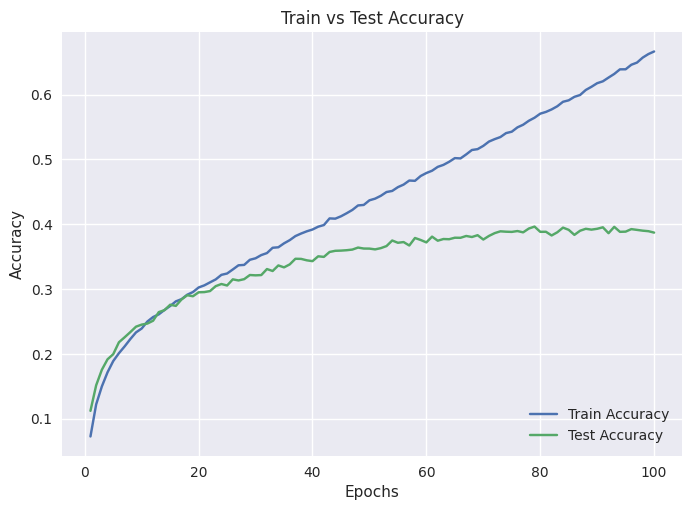

In [14]:
plt.style.use("seaborn")
train_accs_data = [acc.cpu().item() for acc in train_accs]
test_accs_data = [acc.cpu().item() for acc in test_accs]
plt.plot(range(1, 101), train_accs_data, label="Train Accuracy")
plt.plot(range(1, 101), test_accs_data, label="Test Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc="lower right")

In [15]:
pred_labels ,true_labels = test(model, test_dataloader)
true_labels = [label.cpu().item() for label in true_labels]
pred_labels = [label.cpu().item() for label in pred_labels]

100%|██████████| 313/313 [00:03<00:00, 79.60it/s]


####  Superclass confusion matrix

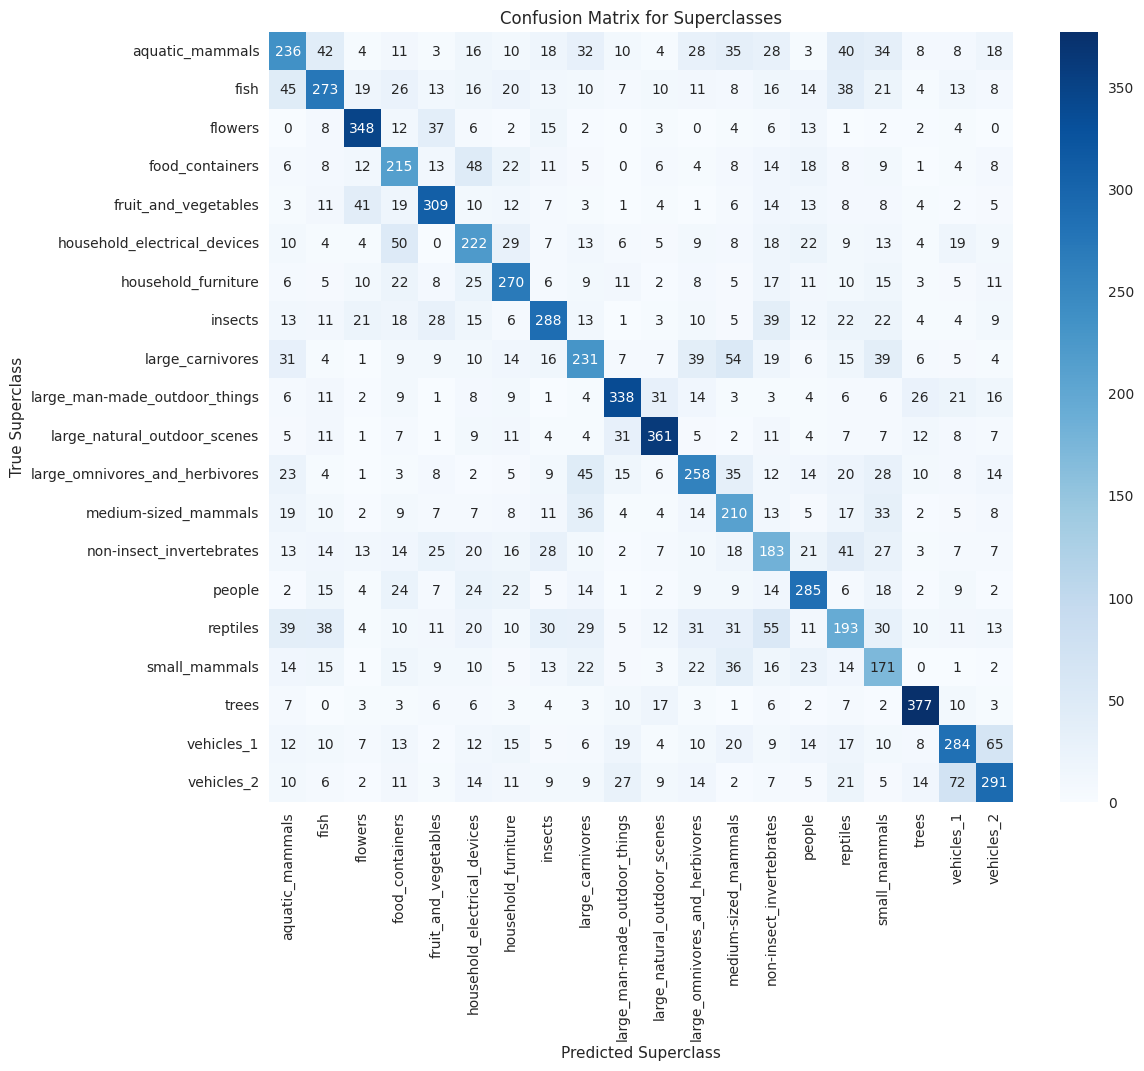

In [16]:
# Confusion matrix for superclass

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)


cm_superclass = confusion_matrix(pred_superclass_labels, true_superclass_labels)

# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_superclass, annot=True, xticklabels=superclass_to_classes.keys(), yticklabels=superclass_to_classes.keys(), cmap="Blues", fmt="d")
plt.xlabel("Predicted Superclass")
plt.ylabel("True Superclass")
plt.title("Confusion Matrix for CIFAR-100 Classification")
plt.title("Confusion Matrix for Superclasses")
plt.show()

####  Childclass confusion matrix

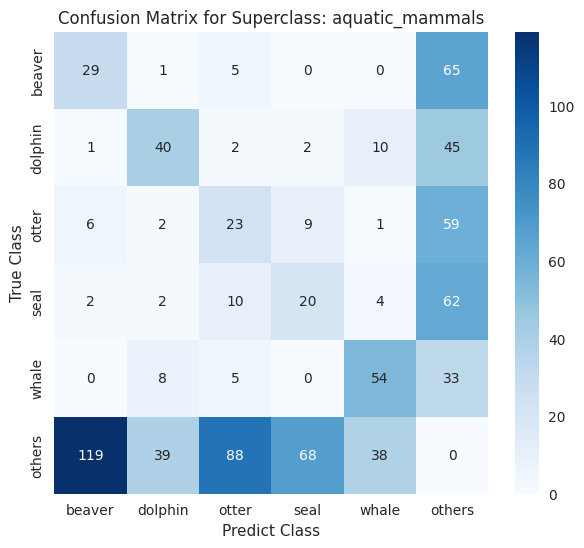

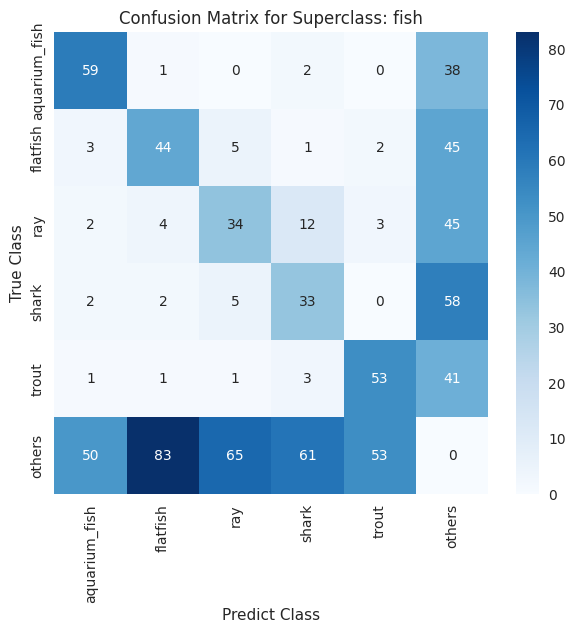

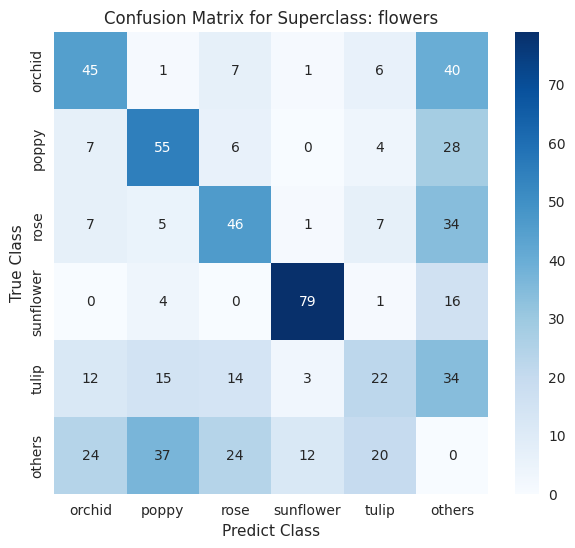

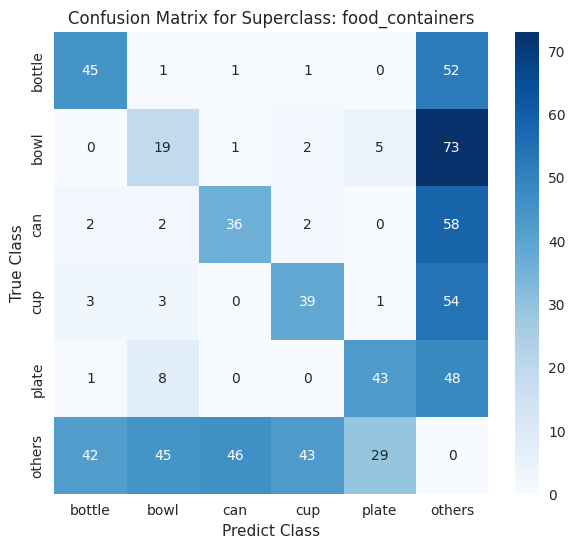

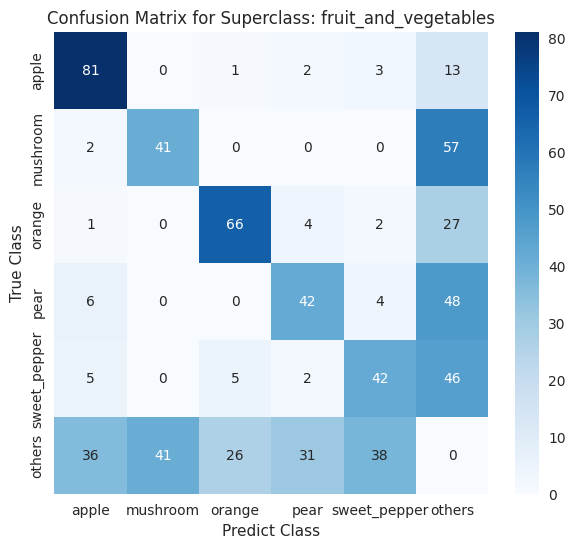

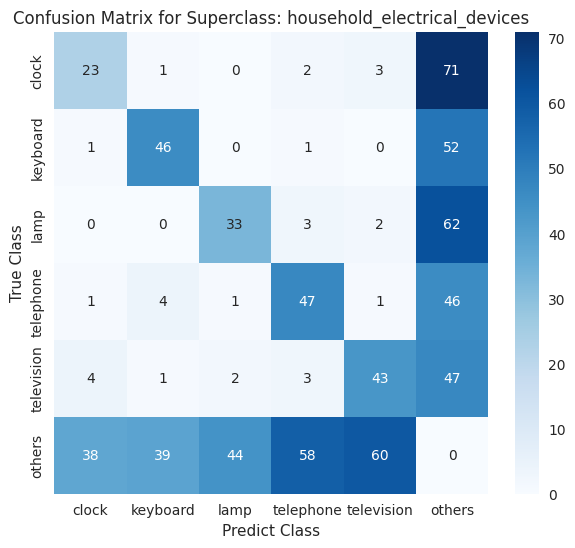

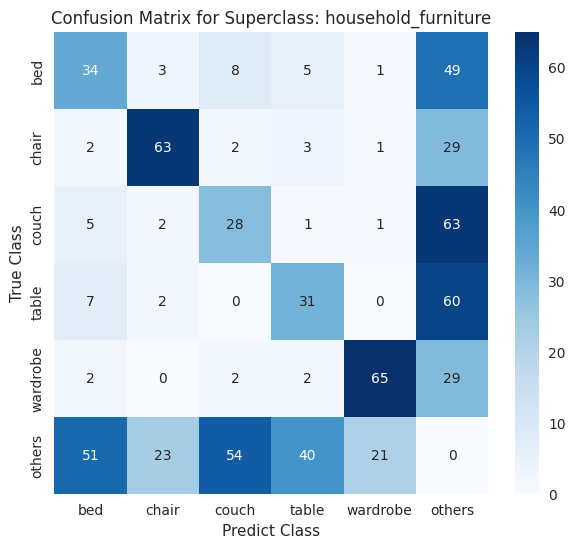

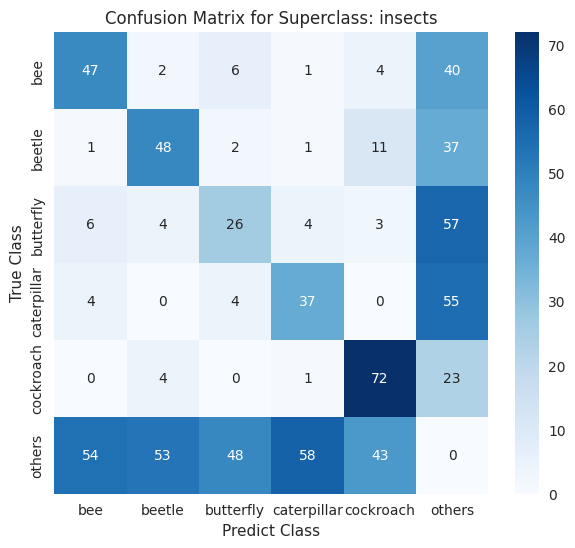

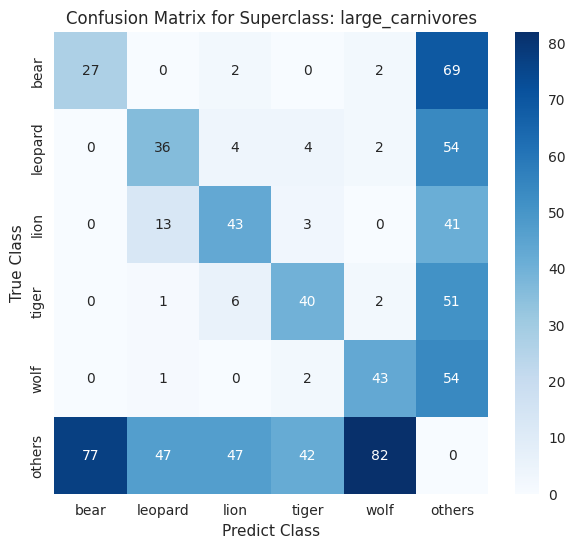

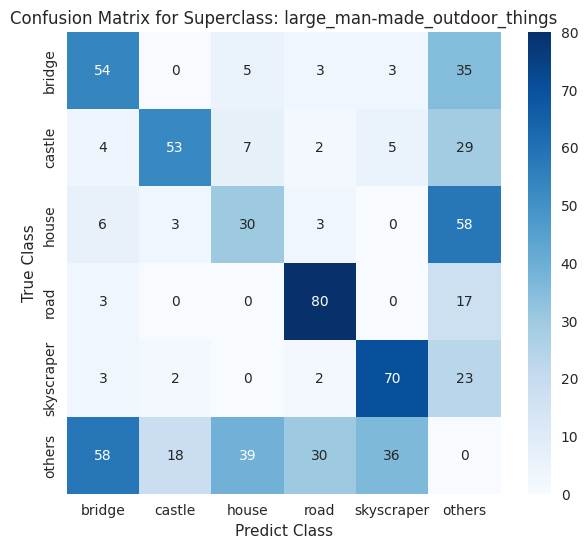

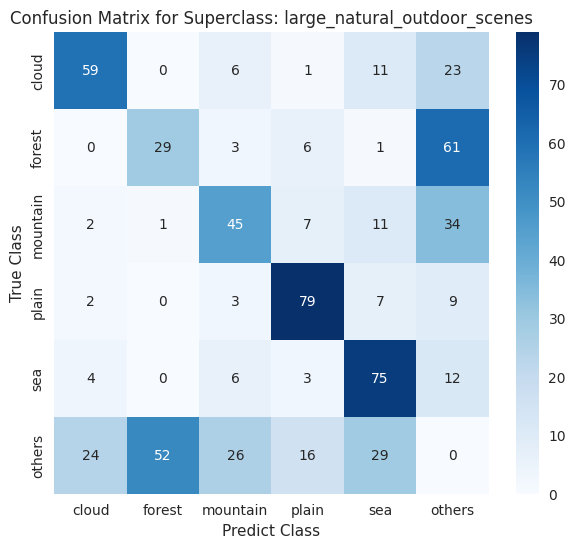

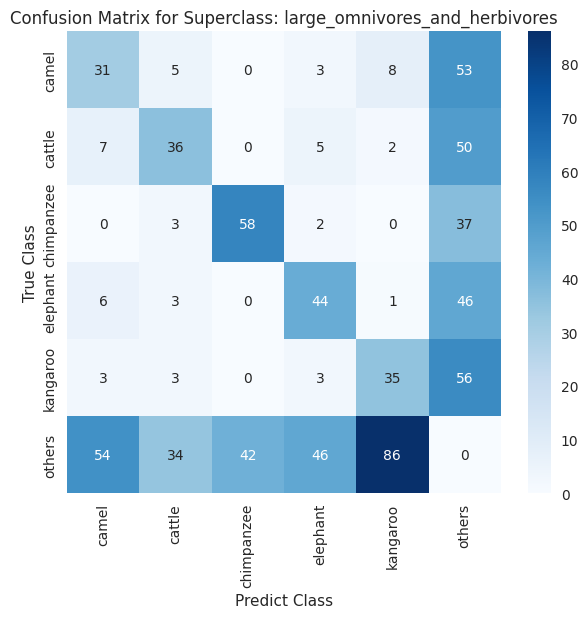

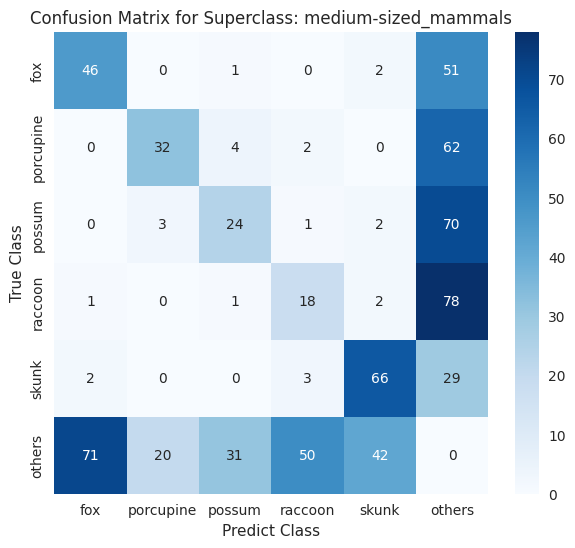

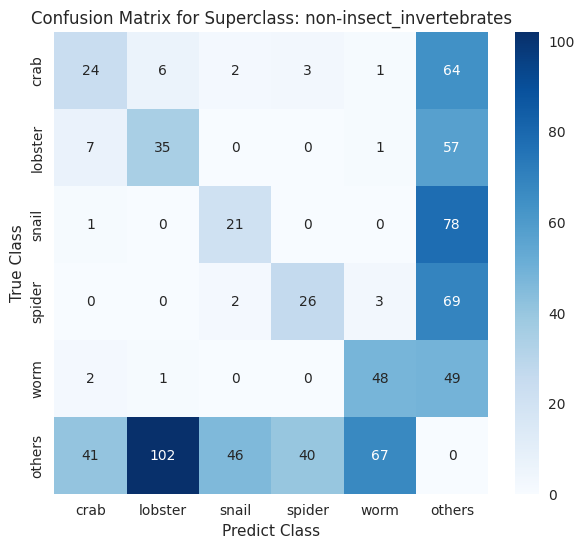

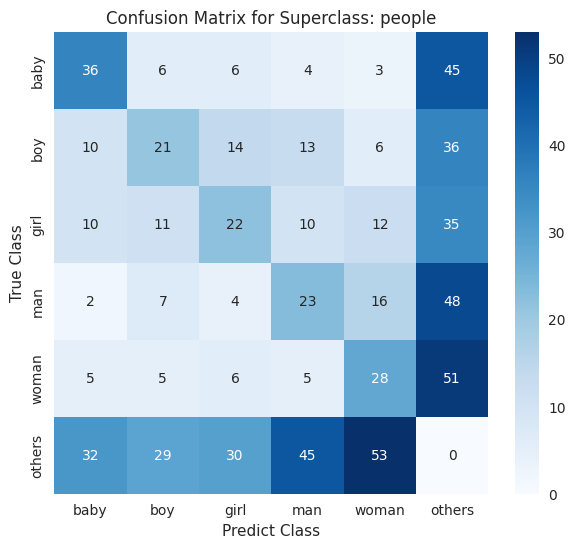

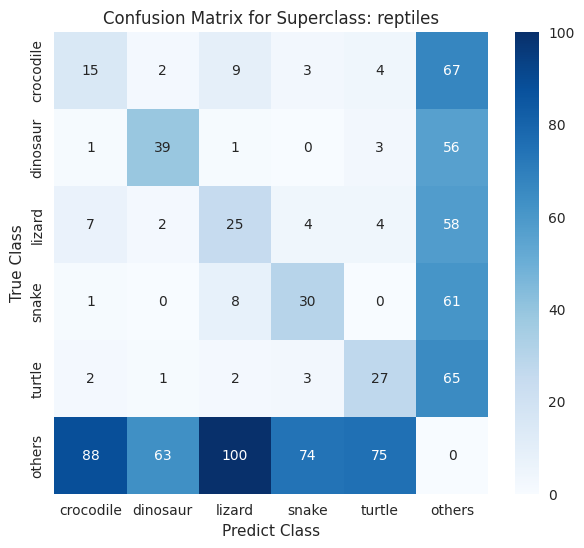

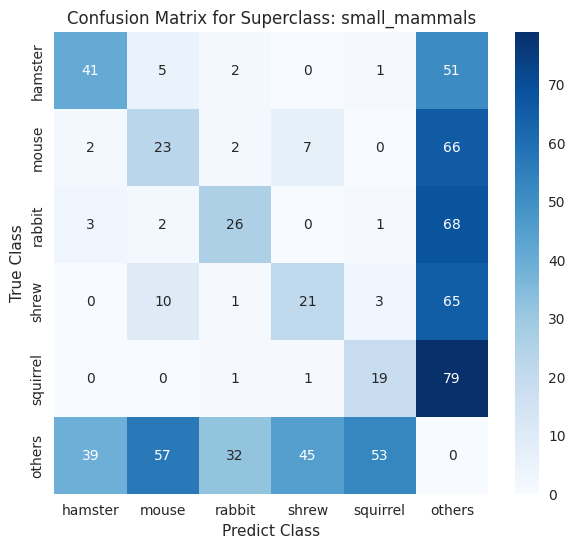

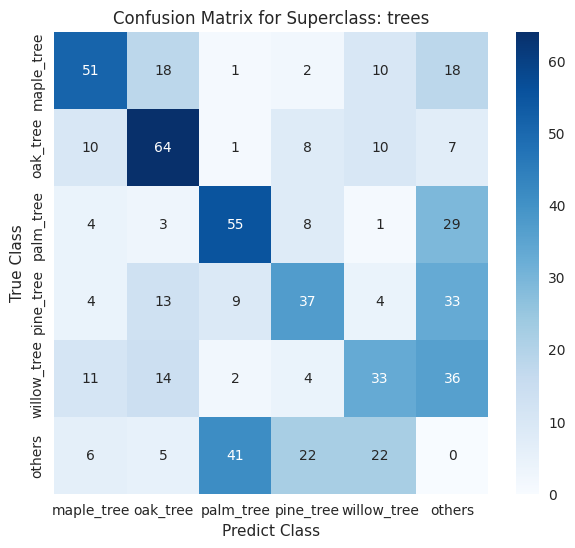

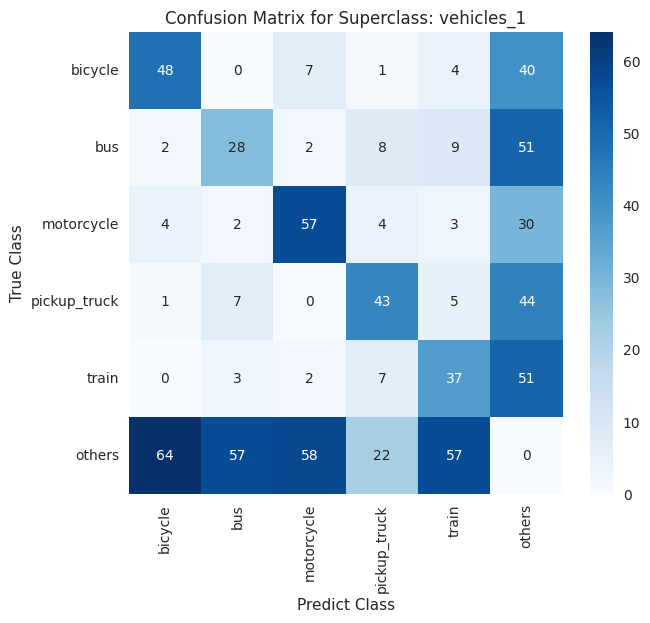

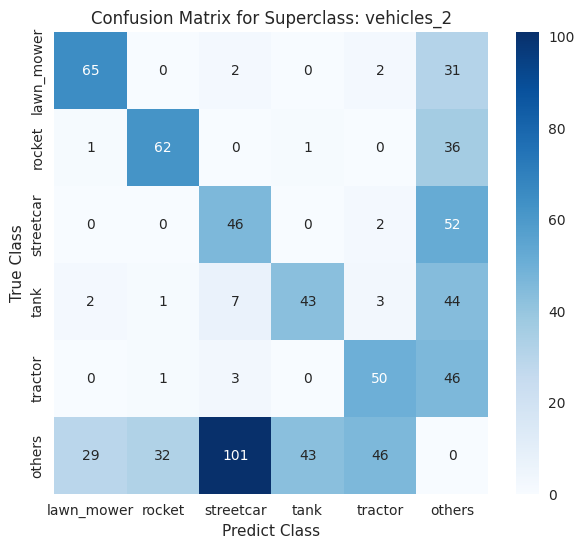

In [17]:
# Confusion matrix for superclass
true_class_labels = list_class_label(true_labels)
pred_class_labels = list_class_label(pred_labels)

superclass = {
    'aquatic_mammals': { 'true_label': [], 'pred_label': [] },
    'fish': { 'true_label': [], 'pred_label': [] },
    'flowers': { 'true_label': [], 'pred_label': [] },
    'food_containers': { 'true_label': [], 'pred_label': [] },
    'fruit_and_vegetables': { 'true_label': [], 'pred_label': [] },
    'household_electrical_devices': { 'true_label': [], 'pred_label': [] },
    'household_furniture': { 'true_label': [], 'pred_label': [] },
    'insects': { 'true_label': [], 'pred_label': [] },
    'large_carnivores': { 'true_label': [], 'pred_label': [] },
    'large_man-made_outdoor_things': { 'true_label': [], 'pred_label': [] },
    'large_natural_outdoor_scenes': { 'true_label': [], 'pred_label': [] },
    'large_omnivores_and_herbivores': { 'true_label': [], 'pred_label': [] },
    'medium-sized_mammals': { 'true_label': [], 'pred_label': [] },
    'non-insect_invertebrates': { 'true_label': [], 'pred_label': [] },
    'people': { 'true_label': [], 'pred_label': [] },
    'reptiles': { 'true_label': [], 'pred_label': [] },
    'small_mammals': { 'true_label': [], 'pred_label': [] },
    'trees': { 'true_label': [], 'pred_label': [] },
    'vehicles_1': { 'true_label': [], 'pred_label': [] },
    'vehicles_2': { 'true_label': [], 'pred_label': [] },
}

child_class = test_dataloader.dataset.classes

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)

for true_label, pred_label in zip(true_class_labels, pred_class_labels):
    true_label_superclass = get_super_by_child(true_label)
    pred_label_superclass = get_super_by_child(pred_label)
    if true_label_superclass == pred_label_superclass:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append(pred_label)
    else:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append('others')
        superclass[f'{pred_label_superclass}']['true_label'].append('others')
        superclass[f'{pred_label_superclass}']['pred_label'].append(pred_label)

colors = [
    "Blues", "BuGn", "BuPu", "GnBu", "OrRd", "PuBu", "PuRd", "RdPu", 
    "YlGn", "YlGnBu", "YlOrBr", "YlOrRd", "Oranges", "Purples", "Greens", 
    "Reds", "coolwarm", "cividis", "magma", "viridis"
]

for super_class, class_label in superclass.items():
    classes = superclass_to_classes[super_class] + ['others']
    cm_class = confusion_matrix(class_label['true_label'], class_label['pred_label'], labels=classes)
    # Vẽ confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_class, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues", fmt="d")
    plt.xlabel("Predict Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for Superclass: {super_class}")
    plt.show()

## **LOAD MODEL AGAIN** 

In [18]:
# # Load previous checkpoint and assign to initial variables
# checkpoint = torch.load("VisionTransformer_CIFAR100_checkpoint.pt")
# last_epoch = checkpoint["epoch"]
# model = checkpoint["model"].to(device)
# optimizer = checkpoint["optimizer"]
# scheduler = checkpoint["scheduler"]
# train_accs = checkpoint["train_acc"]
# test_accs = checkpoint["test_acc"]

In [19]:
from calflops import calculate_flops
input_shape = (batch_size, channels, image_sz, image_sz)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  9.09 M  
fwd MACs:                                                               4.9389 GMACs
fwd FLOPs:                                                              9.9067 GFLOPS
fwd+bwd MACs:                                                           14.8167 GMACs
fwd+bwd FLOPs:                                                          29.7202 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each modu